# Lab: Camera Coordinate Transformations and the View Matrix

## วัตถุประสงค์การเรียนรู้ (Learning Objectives)

เมื่อจบ Lab นี้ นักศึกษาจะสามารถ:
1. อธิบายความแตกต่างระหว่าง World Coordinates และ Camera Coordinates
2. เข้าใจการแปลง (Transformation) จาก World Space ไปยัง Camera Space
3. สร้างและใช้งาน View Matrix (หรือ Extrinsic Matrix) ได้
4. เข้าใจ Homogeneous Coordinates และการใช้งาน
5. Implement การแปลงพิกัดด้วย Python และ NumPy

---

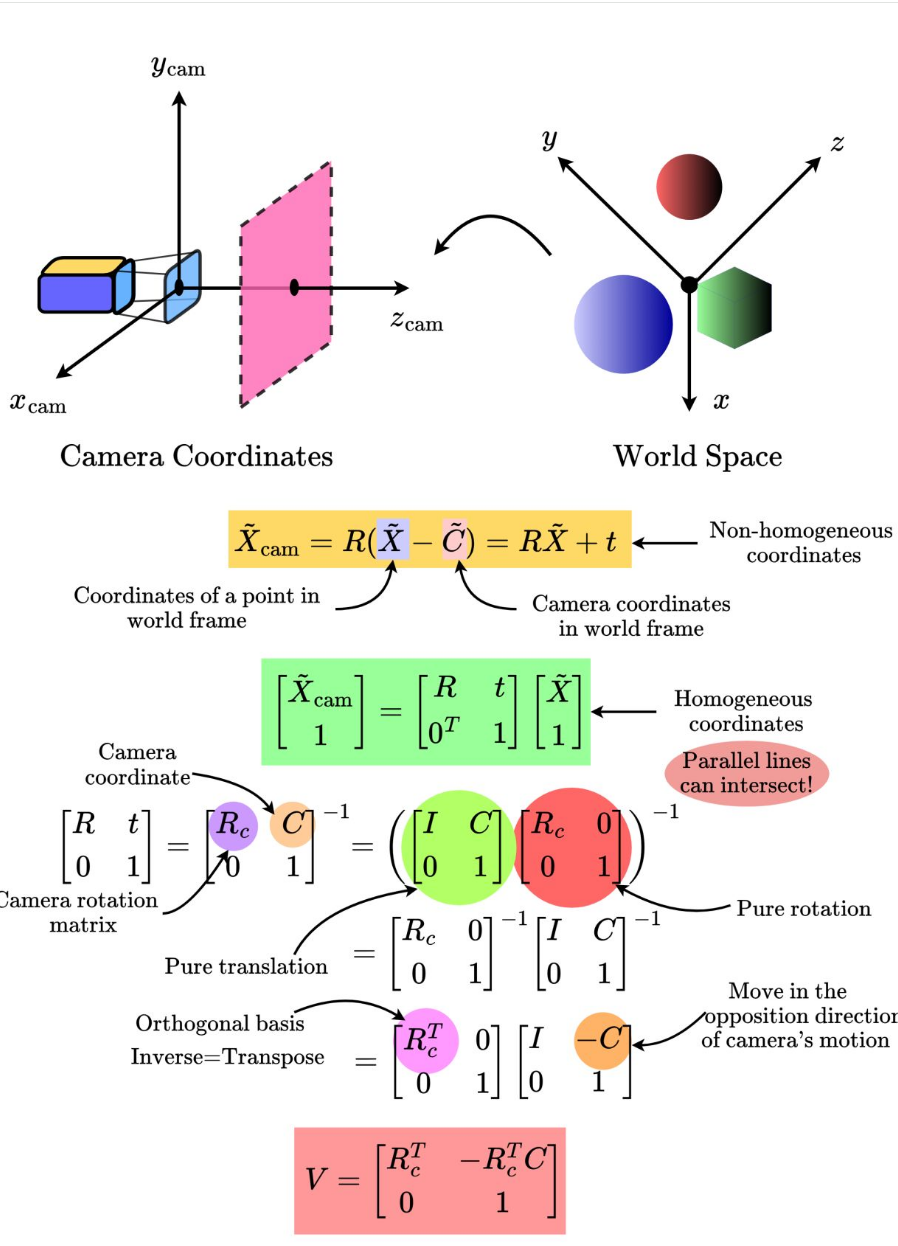

## Part 1: ทฤษฎีพื้นฐาน (Theory)

### 1.1 ระบบพิกัดสองแบบ (Two Coordinate Systems)

ในงาน Computer Vision และ Computer Graphics เราต้องจัดการกับระบบพิกัดหลายแบบ:

**World Coordinates (พิกัดโลก)**
- ระบบพิกัดอ้างอิงหลักที่วัตถุทุกอย่างอยู่
- มีจุดกำเนิด (Origin) และแกน x, y, z คงที่
- ใช้อธิบายตำแหน่งของวัตถุและกล้องในฉาก

**Camera Coordinates (พิกัดกล้อง)**
- ระบบพิกัดที่มีจุดกำเนิดอยู่ที่ตำแหน่งกล้อง
- แกน $z_{cam}$ ชี้ไปทิศทางที่กล้องมอง
- แกน $x_{cam}$ ชี้ไปทางขวาของกล้อง
- แกน $y_{cam}$ ชี้ขึ้นด้านบนของกล้อง

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

### 1.2 การแปลงพิกัด (Coordinate Transformation)

#### สมการพื้นฐาน (Non-Homogeneous Form)

การแปลงจุด $\tilde{X}$ ใน World Space ไปยัง Camera Space:

$$\tilde{X}_{cam} = R(\tilde{X} - \tilde{C}) = R\tilde{X} + t$$

โดยที่:
- $\tilde{X}$ = พิกัดของจุดใน World Frame (3×1 vector)
- $\tilde{C}$ = ตำแหน่งกล้องใน World Frame (3×1 vector)  
- $R$ = Rotation Matrix (3×3)
- $t = -R\tilde{C}$ = Translation Vector

In [2]:
def transform_point_basic(X_world, R, C):
    """
    แปลงจุดจาก World Coordinates ไปยัง Camera Coordinates
    ใช้สมการ: X_cam = R(X - C)
    
    Parameters:
    -----------
    X_world : numpy.ndarray, shape (3,)
        พิกัดจุดใน World Space
    R : numpy.ndarray, shape (3, 3)
        Rotation Matrix ของกล้อง
    C : numpy.ndarray, shape (3,)
        ตำแหน่งกล้องใน World Space
    
    Returns:
    --------
    X_cam : numpy.ndarray, shape (3,)
        พิกัดจุดใน Camera Space
    """
    X_cam = R @ (X_world - C)
    return X_cam

# ตัวอย่าง: กล้องอยู่ที่ตำแหน่ง (5, 3, 2) ไม่มีการหมุน
C = np.array([5, 3, 2])  # Camera position
R = np.eye(3)            # No rotation (Identity matrix)
X_world = np.array([7, 5, 4])  # Point in world space

X_cam = transform_point_basic(X_world, R, C)
print(f"จุดใน World Space: {X_world}")
print(f"ตำแหน่งกล้อง: {C}")
print(f"จุดใน Camera Space: {X_cam}")

จุดใน World Space: [7 5 4]
ตำแหน่งกล้อง: [5 3 2]
จุดใน Camera Space: [2. 2. 2.]


### 1.3 Homogeneous Coordinates

#### ทำไมต้องใช้ Homogeneous Coordinates?

1. **รวม Rotation และ Translation ไว้ใน Matrix เดียว** - ทำให้การแปลงหลายขั้นตอนง่ายขึ้น
2. **Parallel lines can intersect!** - รองรับ Perspective Projection
3. **การคำนวณมีประสิทธิภาพมากขึ้น** - ใช้ Matrix Multiplication แทนที่จะแยก Rotation และ Translation

#### รูปแบบ Homogeneous

$$\begin{bmatrix} \tilde{X}_{cam} \\ 1 \end{bmatrix} = \begin{bmatrix} R & t \\ \mathbf{0}^T & 1 \end{bmatrix} \begin{bmatrix} \tilde{X} \\ 1 \end{bmatrix}$$

Matrix ขนาด 4×4 นี้เรียกว่า **Extrinsic Matrix** หรือ **View Matrix**

In [3]:
def to_homogeneous(point):
    """
    แปลงจุด 3D เป็น Homogeneous Coordinates
    [x, y, z] -> [x, y, z, 1]
    """
    return np.append(point, 1)

def from_homogeneous(point_h):
    """
    แปลงจาก Homogeneous Coordinates กลับเป็น 3D
    [x, y, z, w] -> [x/w, y/w, z/w]
    """
    return point_h[:3] / point_h[3]

# ตัวอย่าง
point_3d = np.array([2, 3, 4])
point_homo = to_homogeneous(point_3d)
point_back = from_homogeneous(point_homo)

print(f"3D Point: {point_3d}")
print(f"Homogeneous: {point_homo}")
print(f"Back to 3D: {point_back}")

3D Point: [2 3 4]
Homogeneous: [2 3 4 1]
Back to 3D: [2. 3. 4.]


---

## Part 2: การสร้าง View Matrix

### 2.1 การแยก Transformation เป็นส่วนประกอบ

View Matrix สามารถแยกได้เป็น:

$$\begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix} = \begin{bmatrix} R_c & C \\ 0 & 1 \end{bmatrix}^{-1}$$

โดยที่ $R_c$ คือ Rotation ของกล้องใน World Space และ $C$ คือตำแหน่งกล้อง

### 2.2 การ Decompose เป็น Pure Translation และ Pure Rotation

$$\begin{bmatrix} R_c & C \\ 0 & 1 \end{bmatrix}^{-1} = \left( \begin{bmatrix} I & C \\ 0 & 1 \end{bmatrix} \begin{bmatrix} R_c & 0 \\ 0 & 1 \end{bmatrix} \right)^{-1}$$

$$= \begin{bmatrix} R_c & 0 \\ 0 & 1 \end{bmatrix}^{-1} \begin{bmatrix} I & C \\ 0 & 1 \end{bmatrix}^{-1}$$

### 2.3 คุณสมบัติของ Rotation Matrix

เนื่องจาก Rotation Matrix เป็น **Orthogonal Matrix**:
- $R^{-1} = R^T$ (Inverse = Transpose)
- $R^T R = I$
- $\det(R) = 1$

$$= \begin{bmatrix} R_c^T & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} I & -C \\ 0 & 1 \end{bmatrix}$$

### 2.4 View Matrix สุดท้าย

$$V = \begin{bmatrix} R_c^T & -R_c^T C \\ 0 & 1 \end{bmatrix}$$

นี่คือ **View Matrix** หรือ **Extrinsic Matrix** ที่ใช้ในการแปลงจาก World Space ไป Camera Space

In [4]:
def create_view_matrix(R_c, C):
    """
    สร้าง View Matrix จาก Camera Rotation และ Position
    
    V = [R_c^T    -R_c^T @ C]
        [0        1         ]
    
    Parameters:
    -----------
    R_c : numpy.ndarray, shape (3, 3)
        Camera Rotation Matrix (orientation of camera in world)
    C : numpy.ndarray, shape (3,)
        Camera Position in World Space
    
    Returns:
    --------
    V : numpy.ndarray, shape (4, 4)
        View Matrix
    """
    V = np.eye(4)
    R_c_T = R_c.T  # Transpose = Inverse for rotation matrix
    V[:3, :3] = R_c_T
    V[:3, 3] = -R_c_T @ C
    return V

# ตัวอย่าง: กล้องอยู่ที่ (5, 3, 2) หันหน้าตามแกน Z
R_c = np.eye(3)  # Camera orientation (no rotation)
C = np.array([5, 3, 2])  # Camera position

V = create_view_matrix(R_c, C)
print("View Matrix V:")
print(V)

View Matrix V:
[[ 1.  0.  0. -5.]
 [ 0.  1.  0. -3.]
 [ 0.  0.  1. -2.]
 [ 0.  0.  0.  1.]]


In [5]:
def transform_point_homogeneous(X_world, V):
    """
    แปลงจุดโดยใช้ View Matrix (Homogeneous)
    
    Parameters:
    -----------
    X_world : numpy.ndarray, shape (3,)
        Point in World Coordinates
    V : numpy.ndarray, shape (4, 4)
        View Matrix
    
    Returns:
    --------
    X_cam : numpy.ndarray, shape (3,)
        Point in Camera Coordinates
    """
    X_homo = to_homogeneous(X_world)
    X_cam_homo = V @ X_homo
    X_cam = from_homogeneous(X_cam_homo)
    return X_cam

# ทดสอบ
X_world = np.array([7, 5, 4])
X_cam_method1 = transform_point_basic(X_world, R_c, C)
X_cam_method2 = transform_point_homogeneous(X_world, V)

print(f"Method 1 (Basic): {X_cam_method1}")
print(f"Method 2 (Homogeneous): {X_cam_method2}")
print(f"Results match: {np.allclose(X_cam_method1, X_cam_method2)}")

Method 1 (Basic): [2. 2. 2.]
Method 2 (Homogeneous): [2. 2. 2.]
Results match: True


---

## Part 3: Rotation Matrices

### 3.1 Basic Rotation Matrices

การหมุนรอบแกนพื้นฐาน:

**Rotation around X-axis (Roll):**
$$R_x(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos\theta & -\sin\theta \\ 0 & \sin\theta & \cos\theta \end{bmatrix}$$

**Rotation around Y-axis (Pitch):**
$$R_y(\theta) = \begin{bmatrix} \cos\theta & 0 & \sin\theta \\ 0 & 1 & 0 \\ -\sin\theta & 0 & \cos\theta \end{bmatrix}$$

**Rotation around Z-axis (Yaw):**
$$R_z(\theta) = \begin{bmatrix} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix}$$

In [6]:
def rotation_x(theta):
    """Rotation matrix around X-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [1, 0,  0],
        [0, c, -s],
        [0, s,  c]
    ])

def rotation_y(theta):
    """Rotation matrix around Y-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [ c, 0, s],
        [ 0, 1, 0],
        [-s, 0, c]
    ])

def rotation_z(theta):
    """Rotation matrix around Z-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ])

# ตัวอย่าง: หมุน 45 องศารอบแกน Z
theta = np.radians(45)
R = rotation_z(theta)
print(f"Rotation 45° around Z-axis:")
print(R)

# ตรวจสอบคุณสมบัติ Orthogonal
print(f"\nR @ R^T = I: {np.allclose(R @ R.T, np.eye(3))}")
print(f"det(R) = 1: {np.allclose(np.linalg.det(R), 1)}")

Rotation 45° around Z-axis:
[[ 0.7071 -0.7071  0.    ]
 [ 0.7071  0.7071  0.    ]
 [ 0.      0.      1.    ]]

R @ R^T = I: True
det(R) = 1: True


### 3.2 Combined Rotations (Euler Angles)

การหมุนรวม (Yaw-Pitch-Roll):

$$R = R_z(\text{yaw}) \cdot R_y(\text{pitch}) \cdot R_x(\text{roll})$$

In [7]:
def euler_to_rotation_matrix(roll, pitch, yaw):
    """
    สร้าง Rotation Matrix จาก Euler Angles (ZYX convention)
    
    Parameters:
    -----------
    roll : float
        Rotation around X-axis (radians)
    pitch : float
        Rotation around Y-axis (radians)
    yaw : float
        Rotation around Z-axis (radians)
    
    Returns:
    --------
    R : numpy.ndarray, shape (3, 3)
        Combined Rotation Matrix
    """
    Rx = rotation_x(roll)
    Ry = rotation_y(pitch)
    Rz = rotation_z(yaw)
    return Rz @ Ry @ Rx

# ตัวอย่าง: กล้องหมุน 30° yaw, 15° pitch, 0° roll
yaw = np.radians(30)
pitch = np.radians(15)
roll = np.radians(0)

R_camera = euler_to_rotation_matrix(roll, pitch, yaw)
print("Camera Rotation Matrix:")
print(R_camera)

Camera Rotation Matrix:
[[ 0.8365 -0.5     0.2241]
 [ 0.483   0.866   0.1294]
 [-0.2588  0.      0.9659]]


---

## Part 4: Visualization

### 4.1 แสดง Coordinate Systems และ Transformations

In [8]:
def draw_coordinate_frame(ax, R, origin, scale=1.0, label=''):
    """
    วาด Coordinate Frame
    
    Parameters:
    -----------
    ax : matplotlib 3D axis
    R : numpy.ndarray (3, 3)
        Rotation matrix defining frame orientation
    origin : numpy.ndarray (3,)
        Origin of the frame
    scale : float
        Length of axes
    label : str
        Label for the frame
    """
    colors = ['r', 'g', 'b']  # X=red, Y=green, Z=blue
    labels = ['X', 'Y', 'Z']
    
    for i in range(3):
        direction = R[:, i] * scale
        ax.quiver(origin[0], origin[1], origin[2],
                  direction[0], direction[1], direction[2],
                  color=colors[i], arrow_length_ratio=0.1,
                  linewidth=2)
    
    if label:
        ax.text(origin[0], origin[1], origin[2] + scale * 0.3, label,
                fontsize=10, fontweight='bold')

def draw_camera(ax, R, C, scale=0.5):
    """
    วาดกล้อง (เป็นรูปพีระมิด)
    """
    # Camera frustum vertices (local coordinates)
    d = scale  # depth
    w = scale * 0.6  # width
    h = scale * 0.4  # height
    
    # Vertices in camera frame
    verts_local = np.array([
        [0, 0, 0],           # apex (camera center)
        [-w, -h, d],         # bottom-left
        [w, -h, d],          # bottom-right
        [w, h, d],           # top-right
        [-w, h, d]           # top-left
    ])
    
    # Transform to world coordinates
    verts_world = (R @ verts_local.T).T + C
    
    # Draw edges
    edges = [[0,1], [0,2], [0,3], [0,4], [1,2], [2,3], [3,4], [4,1]]
    for e in edges:
        ax.plot3D(*verts_world[e].T, 'c-', linewidth=1.5)
    
    # Draw the coordinate frame
    draw_coordinate_frame(ax, R, C, scale=scale*1.5, label='Camera')

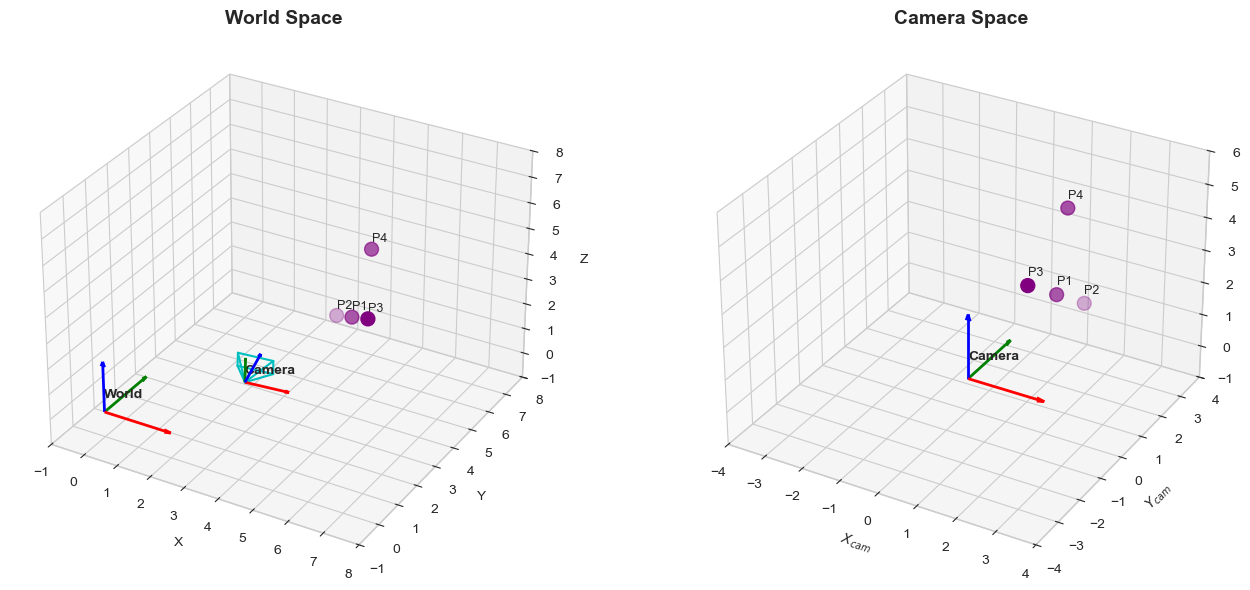


Transformation Details

Camera Position (C): [3 2 1]

Camera Rotation Matrix (R_c):
[[ 0.8138 -0.5     0.2962]
 [ 0.4698  0.866   0.171 ]
 [-0.342   0.      0.9397]]

View Matrix (V):
[[ 0.8138  0.4698 -0.342  -3.0391]
 [-0.5     0.866   0.     -0.2321]
 [ 0.2962  0.171   0.9397 -2.1703]
 [ 0.      0.      0.      1.    ]]

Point Transformations:
----------------------------------------
P1: World [5 4 3] -> Camera [1.8832 0.7321 2.8138]
P2: World [4 5 2] -> Camera [1.8813 2.0981 1.7489]
P3: World [6 3 4] -> Camera [ 1.8852 -0.634   3.8787]
P4: World [5 5 5] -> Camera [1.6691 1.5981 4.8642]


In [9]:
def visualize_transformation():
    """
    แสดงการแปลงจาก World Space ไป Camera Space
    """
    fig = plt.figure(figsize=(14, 6))
    
    # กำหนดกล้องและจุด
    C = np.array([3, 2, 1])  # Camera position
    R_c = euler_to_rotation_matrix(0, np.radians(20), np.radians(30))
    
    # จุดต่างๆ ใน World Space
    points_world = np.array([
        [5, 4, 3],
        [4, 5, 2],
        [6, 3, 4],
        [5, 5, 5]
    ])
    
    # สร้าง View Matrix
    V = create_view_matrix(R_c, C)
    
    # แปลงจุดไป Camera Space
    points_cam = np.array([transform_point_homogeneous(p, V) for p in points_world])
    
    # --- Plot World Space ---
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title('World Space', fontsize=14, fontweight='bold')
    
    # World coordinate frame
    draw_coordinate_frame(ax1, np.eye(3), np.zeros(3), scale=2, label='World')
    
    # Camera
    draw_camera(ax1, R_c, C, scale=0.8)
    
    # Points
    ax1.scatter(*points_world.T, s=100, c='purple', marker='o', label='Points')
    for i, p in enumerate(points_world):
        ax1.text(p[0], p[1], p[2]+0.3, f'P{i+1}', fontsize=9)
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1, 8])
    ax1.set_ylim([-1, 8])
    ax1.set_zlim([-1, 8])
    
    # --- Plot Camera Space ---
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('Camera Space', fontsize=14, fontweight='bold')
    
    # Camera coordinate frame (at origin)
    draw_coordinate_frame(ax2, np.eye(3), np.zeros(3), scale=2, label='Camera')
    
    # Transformed points
    ax2.scatter(*points_cam.T, s=100, c='purple', marker='o', label='Points')
    for i, p in enumerate(points_cam):
        ax2.text(p[0], p[1], p[2]+0.3, f'P{i+1}', fontsize=9)
    
    ax2.set_xlabel('$X_{cam}$')
    ax2.set_ylabel('$Y_{cam}$')
    ax2.set_zlabel('$Z_{cam}$')
    ax2.set_xlim([-4, 4])
    ax2.set_ylim([-4, 4])
    ax2.set_zlim([-1, 6])
    
    plt.tight_layout()
    plt.savefig('coordinate_transformation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print transformation details
    print("\n" + "="*60)
    print("Transformation Details")
    print("="*60)
    print(f"\nCamera Position (C): {C}")
    print(f"\nCamera Rotation Matrix (R_c):")
    print(R_c)
    print(f"\nView Matrix (V):")
    print(V)
    print("\nPoint Transformations:")
    print("-"*40)
    for i, (pw, pc) in enumerate(zip(points_world, points_cam)):
        print(f"P{i+1}: World {pw} -> Camera {pc}")

visualize_transformation()

---

## Part 5: Look-At Matrix

### 5.1 การสร้าง View Matrix จาก Look-At Parameters

ในทางปฏิบัติ เรามักกำหนดกล้องด้วย:
- **Eye** (หรือ C): ตำแหน่งกล้อง
- **Target** (หรือ At): จุดที่กล้องมอง
- **Up**: ทิศทางขึ้นของกล้อง

In [10]:
def look_at(eye, target, up=np.array([0, 1, 0])):
    """
    สร้าง View Matrix จาก Look-At parameters
    
    Parameters:
    -----------
    eye : numpy.ndarray (3,)
        Camera position
    target : numpy.ndarray (3,)
        Point camera is looking at
    up : numpy.ndarray (3,)
        Up direction (default: Y-up)
    
    Returns:
    --------
    V : numpy.ndarray (4, 4)
        View Matrix
    """
    # Forward direction (camera looks down -Z in camera space)
    forward = target - eye
    forward = forward / np.linalg.norm(forward)
    
    # Right direction
    right = np.cross(forward, up)
    right = right / np.linalg.norm(right)
    
    # True up direction
    true_up = np.cross(right, forward)
    
    # Camera rotation matrix (columns are camera axes in world space)
    R_c = np.column_stack([right, true_up, -forward])
    
    return create_view_matrix(R_c, eye)

# ตัวอย่าง: กล้องอยู่ที่ (5, 3, 5) มองไปที่จุด origin
eye = np.array([5, 3, 5])
target = np.array([0, 0, 0])

V_lookat = look_at(eye, target)
print("Look-At View Matrix:")
print(V_lookat)

Look-At View Matrix:
[[ 0.7071  0.     -0.7071  0.    ]
 [-0.2762  0.9206 -0.2762  0.    ]
 [ 0.6509  0.3906  0.6509 -7.6811]
 [ 0.      0.      0.      1.    ]]


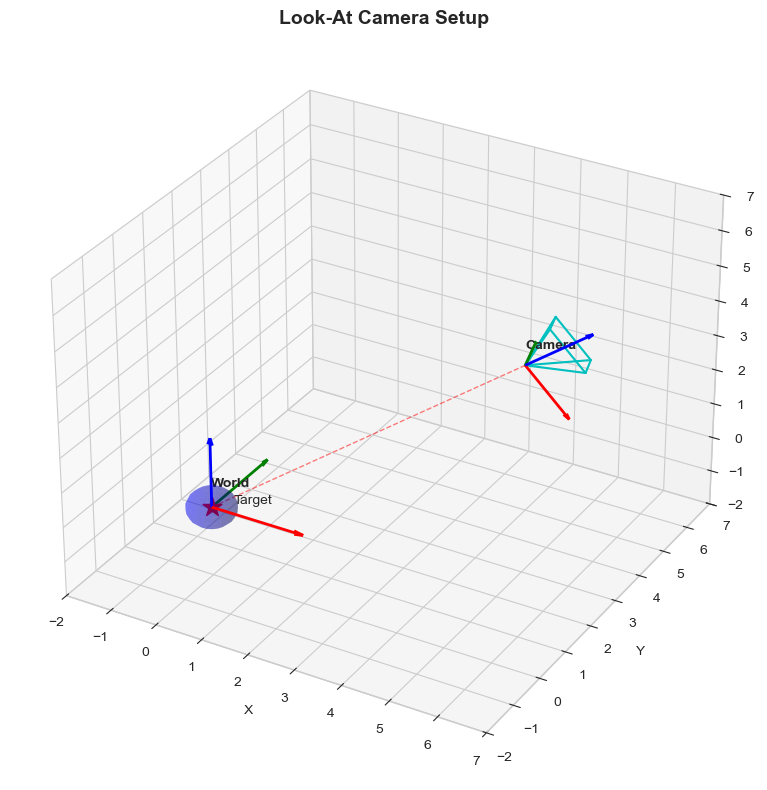


Eye (Camera Position): [5 3 4]
Target: [0 0 0]

View Matrix:
[[ 0.6247  0.     -0.7809 -0.    ]
 [-0.3313  0.9055 -0.265   0.    ]
 [ 0.7071  0.4243  0.5657 -7.0711]
 [ 0.      0.      0.      1.    ]]


In [11]:
def visualize_look_at():
    """
    แสดง Look-At Transformation
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Camera parameters
    eye = np.array([5, 3, 4])
    target = np.array([0, 0, 0])
    up = np.array([0, 1, 0])
    
    # สร้าง Look-At matrix
    V = look_at(eye, target, up)
    
    # คำนวณ Camera axes
    forward = target - eye
    forward = forward / np.linalg.norm(forward)
    right = np.cross(forward, up)
    right = right / np.linalg.norm(right)
    true_up = np.cross(right, forward)
    
    R_c = np.column_stack([right, true_up, -forward])
    
    # Draw world frame
    draw_coordinate_frame(ax, np.eye(3), np.zeros(3), scale=2, label='World')
    
    # Draw camera
    draw_camera(ax, R_c, eye, scale=1.0)
    
    # Draw target point
    ax.scatter(*target, s=200, c='red', marker='*', label='Target')
    ax.text(target[0]+0.3, target[1]+0.3, target[2], 'Target', fontsize=10)
    
    # Draw line from camera to target
    ax.plot3D([eye[0], target[0]], [eye[1], target[1]], [eye[2], target[2]],
              'r--', linewidth=1, alpha=0.5)
    
    # Create some objects in the scene
    # Sphere at origin
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 10)
    x = 0.5 * np.outer(np.cos(u), np.sin(v))
    y = 0.5 * np.outer(np.sin(u), np.sin(v))
    z = 0.5 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='blue', alpha=0.3)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Look-At Camera Setup', fontsize=14, fontweight='bold')
    ax.set_xlim([-2, 7])
    ax.set_ylim([-2, 7])
    ax.set_zlim([-2, 7])
    
    plt.tight_layout()
    plt.savefig('look_at_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nEye (Camera Position): {eye}")
    print(f"Target: {target}")
    print(f"\nView Matrix:")
    print(V)

visualize_look_at()

---

## Part 6: Exercises

### Exercise 1: Basic Transformation

กล้องตั้งอยู่ที่ตำแหน่ง $(2, 1, 3)$ และไม่มีการหมุน จุด P อยู่ที่ $(5, 4, 6)$ ใน World Space

จงคำนวณ:
1. View Matrix
2. พิกัดของจุด P ใน Camera Space

In [12]:
# Exercise 1: เขียนโค้ดที่นี่

# กำหนดค่า
C_ex1 = np.array([2, 1, 3])  # Camera position
R_c_ex1 = np.eye(3)          # No rotation
P_world = np.array([5, 4, 6])  # Point in world space

# TODO: สร้าง View Matrix
V_ex1 = None  # แทนที่ None ด้วยคำตอบ

# TODO: แปลงจุด P ไป Camera Space
P_cam = None  # แทนที่ None ด้วยคำตอบ

# Uncomment เพื่อตรวจคำตอบ
# print("View Matrix:")
# print(V_ex1)
# print(f"\nPoint in Camera Space: {P_cam}")

In [13]:
# Solution Exercise 1
V_ex1_solution = create_view_matrix(R_c_ex1, C_ex1)
P_cam_solution = transform_point_homogeneous(P_world, V_ex1_solution)

print("Solution:")
print("View Matrix:")
print(V_ex1_solution)
print(f"\nPoint in Camera Space: {P_cam_solution}")
print(f"\nExpected: [3, 3, 3] (เพราะกล้องไม่หมุน แค่เลื่อนตำแหน่ง)")

Solution:
View Matrix:
[[ 1.  0.  0. -2.]
 [ 0.  1.  0. -1.]
 [ 0.  0.  1. -3.]
 [ 0.  0.  0.  1.]]

Point in Camera Space: [3. 3. 3.]

Expected: [3, 3, 3] (เพราะกล้องไม่หมุน แค่เลื่อนตำแหน่ง)


### Exercise 2: Rotation and Translation

กล้องอยู่ที่ $(4, 0, 0)$ และหมุนรอบแกน Y ไป $90°$ (มองไปทางแกน -X)

จุด $(0, 0, 0)$ จะอยู่ที่ไหนใน Camera Space?

In [14]:
# Exercise 2: เขียนโค้ดที่นี่

# กำหนดค่า
C_ex2 = np.array([4, 0, 0])
theta_y = np.radians(90)  # 90 degrees

# TODO: สร้าง Rotation Matrix (หมุนรอบ Y)
R_c_ex2 = None

# TODO: สร้าง View Matrix
V_ex2 = None

# TODO: แปลงจุด origin
origin_cam = None

# print(f"Origin in Camera Space: {origin_cam}")

In [15]:
# Solution Exercise 2
R_c_ex2_solution = rotation_y(np.radians(90))
V_ex2_solution = create_view_matrix(R_c_ex2_solution, C_ex2)
origin_cam_solution = transform_point_homogeneous(np.array([0, 0, 0]), V_ex2_solution)

print("Solution:")
print(f"Camera Rotation Matrix (90° around Y):")
print(R_c_ex2_solution)
print(f"\nView Matrix:")
print(V_ex2_solution)
print(f"\nOrigin in Camera Space: {origin_cam_solution}")
print(f"\nExplanation: Origin อยู่หน้ากล้อง 4 หน่วย (Z = 4 ใน camera space)")

Solution:
Camera Rotation Matrix (90° around Y):
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]

View Matrix:
[[ 0.  0. -1. -0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0. -4.]
 [ 0.  0.  0.  1.]]

Origin in Camera Space: [-0.  0. -4.]

Explanation: Origin อยู่หน้ากล้อง 4 หน่วย (Z = 4 ใน camera space)


### Exercise 3: Look-At Camera

สร้างกล้องที่:
- ตั้งอยู่ที่ $(3, 3, 3)$
- มองไปที่จุด $(0, 0, 0)$
- Up vector เป็น $(0, 1, 0)$

จุด $(1, 0, 0)$ จะอยู่ที่ไหนใน Camera Space?

In [16]:
# Exercise 3: เขียนโค้ดที่นี่

eye_ex3 = np.array([3, 3, 3])
target_ex3 = np.array([0, 0, 0])
up_ex3 = np.array([0, 1, 0])
point_ex3 = np.array([1, 0, 0])

# TODO: สร้าง Look-At View Matrix
V_ex3 = None

# TODO: แปลงจุด
point_cam_ex3 = None

# print(f"Point (1,0,0) in Camera Space: {point_cam_ex3}")

In [17]:
# Solution Exercise 3
V_ex3_solution = look_at(eye_ex3, target_ex3, up_ex3)
point_cam_ex3_solution = transform_point_homogeneous(point_ex3, V_ex3_solution)

print("Solution:")
print(f"Look-At View Matrix:")
print(V_ex3_solution)
print(f"\nPoint (1,0,0) in Camera Space: {point_cam_ex3_solution}")

Solution:
Look-At View Matrix:
[[ 0.7071  0.     -0.7071  0.    ]
 [-0.4082  0.8165 -0.4082  0.    ]
 [ 0.5774  0.5774  0.5774 -5.1962]
 [ 0.      0.      0.      1.    ]]

Point (1,0,0) in Camera Space: [ 0.7071 -0.4082 -4.6188]


### Exercise 4: Verify Orthogonality

เขียน function เพื่อตรวจสอบว่า matrix เป็น valid rotation matrix หรือไม่

In [18]:
def is_valid_rotation_matrix(R, tolerance=1e-6):
    """
    ตรวจสอบว่า R เป็น valid rotation matrix หรือไม่
    
    เงื่อนไข:
    1. R @ R^T = I (orthogonal)
    2. det(R) = 1 (proper rotation, not reflection)
    
    Parameters:
    -----------
    R : numpy.ndarray (3, 3)
        Matrix to check
    tolerance : float
        Numerical tolerance
    
    Returns:
    --------
    bool : True if valid rotation matrix
    """
    # TODO: Implement this function
    pass

# Test cases
R_valid = rotation_z(np.radians(45))
R_invalid_det = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])  # det = -1 (reflection)
R_invalid_orthogonal = np.array([[1, 1, 0], [0, 1, 0], [0, 0, 1]])  # not orthogonal

# print(f"Valid rotation: {is_valid_rotation_matrix(R_valid)}")
# print(f"Reflection (det=-1): {is_valid_rotation_matrix(R_invalid_det)}")
# print(f"Non-orthogonal: {is_valid_rotation_matrix(R_invalid_orthogonal)}")

In [19]:
# Solution Exercise 4
def is_valid_rotation_matrix_solution(R, tolerance=1e-6):
    """
    ตรวจสอบว่า R เป็น valid rotation matrix หรือไม่
    """
    # Check orthogonality: R @ R^T should be identity
    is_orthogonal = np.allclose(R @ R.T, np.eye(3), atol=tolerance)
    
    # Check determinant = 1 (proper rotation)
    det = np.linalg.det(R)
    is_proper = np.abs(det - 1.0) < tolerance
    
    return is_orthogonal and is_proper

# Test
print("Testing rotation matrices:")
print(f"Valid rotation (45° around Z): {is_valid_rotation_matrix_solution(R_valid)}")
print(f"Reflection (det=-1): {is_valid_rotation_matrix_solution(R_invalid_det)}")
print(f"Non-orthogonal: {is_valid_rotation_matrix_solution(R_invalid_orthogonal)}")

Testing rotation matrices:
Valid rotation (45° around Z): True
Reflection (det=-1): False
Non-orthogonal: False


---

## Part 7: Summary

### สรุปสิ่งที่เรียนรู้

1. **Coordinate Systems**
   - World Space: ระบบพิกัดอ้างอิงหลัก
   - Camera Space: ระบบพิกัดที่มีกล้องเป็นศูนย์กลาง

2. **Basic Transformation**
   - $\tilde{X}_{cam} = R(\tilde{X} - \tilde{C})$

3. **Homogeneous Coordinates**
   - ช่วยรวม rotation และ translation ใน matrix เดียว
   - รองรับ perspective projection

4. **View Matrix**
   $$V = \begin{bmatrix} R_c^T & -R_c^T C \\ 0 & 1 \end{bmatrix}$$

5. **Rotation Matrix Properties**
   - Orthogonal: $R^{-1} = R^T$
   - Determinant = 1

6. **Look-At Matrix**
   - สะดวกในการกำหนดกล้องด้วย eye, target, up

### การบ้าน (Homework)

1. **Implement Inverse View Matrix**: สร้าง function ที่แปลงจาก Camera Space กลับไป World Space

2. **Animation**: สร้าง animation ของกล้องที่โคจรรอบจุด origin

3. **Multiple Cameras**: สร้างระบบที่มีหลายกล้อง และแสดงว่าจุดเดียวกันมองจากกล้องต่างๆ เป็นอย่างไร

4. **Chain Transformations**: ถ้ามี Robot Arm ที่มีหลาย joints จะ chain transformations อย่างไร

---

## References

1. Hartley, R., & Zisserman, A. (2003). *Multiple View Geometry in Computer Vision*. Cambridge University Press.
2. Szeliski, R. (2022). *Computer Vision: Algorithms and Applications*. Springer.
3. OpenGL View Matrix: https://learnopengl.com/Getting-started/Camera
4. Computer Graphics: Principles and Practice (3rd Edition)